In [ ]:
import numpy as np

def WaterFilling_alg(PtotA, ChA, B, N0):
    """
    WaterFilling in Optimising the Capacity
    
    Parameters:
    -----------
    PtotA : float
        Total power
    ChA : array-like
        Channel gains
    B : float
        Bandwidth
    N0 : float
        Noise power
        
    Returns:
    --------
    Capacity : float
        Channel capacity
    PowerAllo : ndarray
        Power allocation
    """
    # Initialization
    ChA = np.array(ChA).flatten()
    NA = len(ChA)  # the number of subchannels allocated to
    
    H = ChA**2 / (B * N0)  # the parameter related to SNR in subchannels
    
    # Assign the power to subchannel
    PowerAllo = (PtotA + np.sum(1./H)) / NA - 1./H
    
    while len(np.where(PowerAllo < 0)[0]) > 0:
        IndexN = np.where(PowerAllo <= 0)[0]
        IndexP = np.where(PowerAllo > 0)[0]
        MP = len(IndexP)
        PowerAllo[IndexN] = 0
        
        ChAT = ChA[IndexP]
        HT = ChAT**2 / (B * N0)
        PowerAlloT = (PtotA + np.sum(1./HT)) / MP - 1./HT
        PowerAllo[IndexP] = PowerAlloT
    
    PowerAllo = PowerAllo.T
    Capacity = np.sum(np.log2(1 + PowerAllo.T * H))
    
    return Capacity, PowerAllo

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30


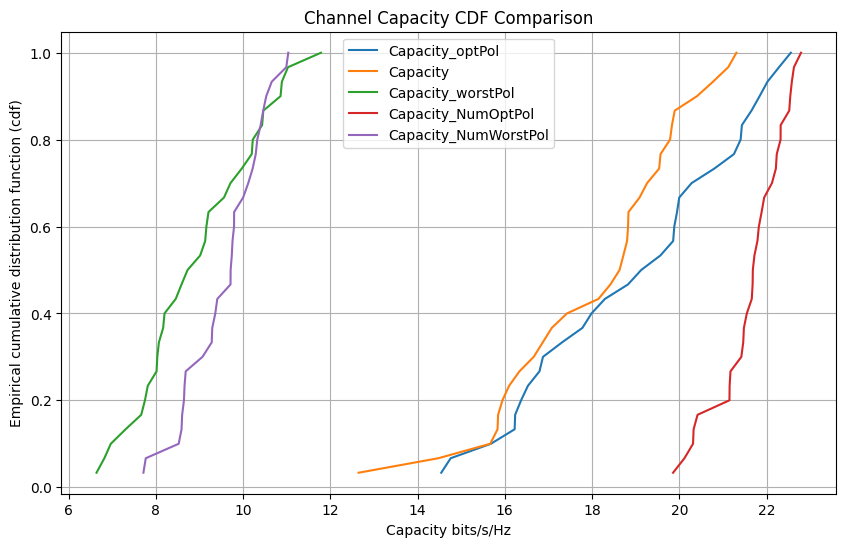

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ecdf
from scipy.linalg import svd, eig

# Clear all variables and set up parameters
np.random.seed(None)  # For random results each run

# Configuration
nt_V = [1, 2, 3, 4]
nr_V = [1, 2, 3, 4]

N0 = 1e-4
B = 1
Iteration = 30  # Reduced for faster execution, increase as needed
N_Joint_PrePostCoding = 5

# SNR_V_db = np.arange(-10, 21, 3)  # original
SNR_V_db = np.arange(0, 31, 3)  # high SNR
SNR_V = 10**(SNR_V_db/10)

# Angle bins for brute force search
theta_Tx1_bin = np.arange(1, 20)
theta_Tx2_bin = np.arange(1, 20)
theta_Tx1_bin_rad = (theta_Tx1_bin - 1) * 10 * np.pi/180
theta_Tx2_bin_rad = (theta_Tx2_bin - 1) * 10 * np.pi/180

theta_Rx1_bin = np.arange(1, 20)
theta_Rx2_bin = np.arange(1, 20)
theta_Rx1_bin_rad = (theta_Rx1_bin - 1) * 10 * np.pi/180
theta_Rx2_bin_rad = (theta_Rx2_bin - 1) * 10 * np.pi/180

brute_force_numerical_search = 1

# Main simulation loop
k = 2  # Select antenna configuration (2x2 MIMO)
nt = nt_V[k-1]  # Python uses 0-indexing
nr = nr_V[k-1]

# Initialize arrays
Pol_Tx = np.zeros((nt, 2))
Pol_Rx = np.zeros((nr, 2))
Pol_Tx_Opt = np.zeros((nt, 2))
Pol_Rx_Opt = np.zeros((nr, 2))
Pol_Tx_Worst = np.zeros((nt, 2))
Pol_Rx_Worst = np.zeros((nr, 2))
H_PD_Tx = np.zeros((nt, 2, 2), dtype=complex)
H_PD_Rx = np.zeros((nr, 2, 2), dtype=complex)
theta_Tx = np.zeros(nt)
theta_Rx = np.zeros(nr)

i = 10  # SNR_V_db = 30 dB
Pt = N0 * SNR_V[i]

# Storage arrays
Capacity = np.zeros(Iteration)
Capacity_optPol = np.zeros(Iteration)
Capacity_worstPol = np.zeros(Iteration)
Capacity_NumOptPol = np.zeros(Iteration)
Capacity_NumWorstPol = np.zeros(Iteration)
lambdas = np.zeros((min(nt, nr), Iteration))
lambdas_optPol = np.zeros((min(nt, nr), Iteration))
lambdas_worstPol = np.zeros((min(nt, nr), Iteration))

for n_iteration in range(Iteration):
    print(f"Iteration: {n_iteration + 1}")
    
    # Generate channel matrices
    H_re = np.random.normal(0, 1, (nr, nt))
    H_im = np.random.normal(0, 1, (nr, nt))
    
    H_randPol = (H_re + 1j*H_im) / np.sqrt(2)
    H_optPol = (H_re + 1j*H_im) / np.sqrt(2)
    H_worstPol = (H_re + 1j*H_im) / np.sqrt(2)
    H_NumPol = (H_re + 1j*H_im) / np.sqrt(2)
    
    # Generate polarized channel matrices
    H_p_re = np.random.normal(0, 1, (nr, nt, 2, 2))
    H_p_im = np.random.normal(0, 1, (nr, nt, 2, 2))
    H_p = (H_p_re + 1j*H_p_im) / np.sqrt(2)
    
    # Random antenna rotation with orthogonal dual-pol antennas
    # Random Rx polarization vectors
    for n_Rx in range(nr):
        theta_rand_Rx = np.random.rand() * (2*np.pi)
        Pol_Rx[n_Rx, 0] = np.cos(theta_rand_Rx)
        Pol_Rx[n_Rx, 1] = np.sin(theta_rand_Rx)
    
    # Random Tx polarization vectors
    for n_Tx in range(nt):
        theta_rand_Tx = np.random.rand() * (2*np.pi)
        Pol_Tx[n_Tx, 0] = np.cos(theta_rand_Tx)
        Pol_Tx[n_Tx, 1] = np.sin(theta_rand_Tx)
    
    # Initialize optimal polarization vectors
    for n_Rx in range(nr):
        Pol_Rx_Opt[n_Rx, 0] = np.cos(0)
        Pol_Rx_Opt[n_Rx, 1] = np.sin(0)
    
    for n_Tx in range(nt):
        Pol_Tx_Opt[n_Tx, 0] = np.cos(0)
        Pol_Tx_Opt[n_Tx, 1] = np.sin(0)
    
    # Channel Capacity with Random Pol. vectors
    for n_Tx in range(nt):
        for n_Rx in range(nr):
            Pol_Rx_temp = Pol_Rx[n_Rx, :].reshape(-1, 1)
            Pol_Tx_temp = Pol_Tx[n_Tx, :].reshape(-1, 1)
            H_p_temp = H_p[n_Rx, n_Tx, :, :]
            H_randPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
    
    U, Sigma, V = svd(H_randPol)
    lambdas[:len(Sigma), n_iteration] = Sigma[:min(nt, nr)]
    Capacity[n_iteration], PowerAllo = WaterFilling_alg(Pt, lambdas[:, n_iteration], B, N0)
    
    # Channel Capacity with Numerical Opt and Worst Pol. vectors
    if brute_force_numerical_search == 1:
        Capacity_max_numerical = 0
        Capacity_min_numerical = 1000
        
        # Simplified brute force search (reduced for performance)
        for n_theta_Tx1 in range(0, len(theta_Tx1_bin), 2):  # Skip every other angle
            Pol_Tx[0, 0] = np.cos(theta_Tx1_bin_rad[n_theta_Tx1])
            Pol_Tx[0, 1] = np.sin(theta_Tx1_bin_rad[n_theta_Tx1])
            
            for n_theta_Tx2 in range(0, len(theta_Tx2_bin), 2):
                if nt > 1:
                    Pol_Tx[1, 0] = np.cos(theta_Tx2_bin_rad[n_theta_Tx2])
                    Pol_Tx[1, 1] = np.sin(theta_Tx2_bin_rad[n_theta_Tx2])
                
                for n_theta_Rx1 in range(0, len(theta_Rx1_bin), 2):
                    Pol_Rx[0, 0] = np.cos(theta_Rx1_bin_rad[n_theta_Rx1])
                    Pol_Rx[0, 1] = np.sin(theta_Rx1_bin_rad[n_theta_Rx1])
                    
                    for n_theta_Rx2 in range(0, len(theta_Rx2_bin), 2):
                        if nr > 1:
                            Pol_Rx[1, 0] = np.cos(theta_Rx2_bin_rad[n_theta_Rx2])
                            Pol_Rx[1, 1] = np.sin(theta_Rx2_bin_rad[n_theta_Rx2])
                        
                        # Calculate channel with current polarization
                        for n_Tx in range(nt):
                            for n_Rx in range(nr):
                                Pol_Rx_temp = Pol_Rx[n_Rx, :].reshape(-1, 1)
                                Pol_Tx_temp = Pol_Tx[n_Tx, :].reshape(-1, 1)
                                H_p_temp = H_p[n_Rx, n_Tx, :, :]
                                H_NumPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
                        
                        U_NumPol, Sigma_NumPol, V_NumPol = svd(H_NumPol)
                        lambdas_NumPol = Sigma_NumPol[:min(nt, nr)]
                        Capacity_NumPol, _ = WaterFilling_alg(Pt, lambdas_NumPol, B, N0)
                        
                        if Capacity_max_numerical <= Capacity_NumPol:
                            Capacity_max_numerical = Capacity_NumPol
                        if Capacity_min_numerical >= Capacity_NumPol:
                            Capacity_min_numerical = Capacity_NumPol
        
        Capacity_NumOptPol[n_iteration] = Capacity_max_numerical
        Capacity_NumWorstPol[n_iteration] = Capacity_min_numerical
    
    # Channel Capacity with Opt and Worst Pol. vectors (Joint optimization)
    for n_PrePostCoding in range(N_Joint_PrePostCoding):
        # Tx-Pol precoding
        for n_Tx in range(nt):
            H_PD_Tx_temp = np.zeros((2, 2), dtype=complex)
            for n_Rx in range(nr):
                H_p_temp = H_p[n_Rx, n_Tx, :, :]
                Pol_Rx_Opt_temp = Pol_Rx_Opt[n_Rx, :].reshape(-1, 1)
                H_PD_Tx_temp = H_PD_Tx_temp + H_p_temp.T @ Pol_Rx_Opt_temp @ Pol_Rx_Opt_temp.T @ H_p_temp
            
            H_PD_Tx[n_Tx, :, :] = H_PD_Tx_temp
            eigenvalues, eigenvectors = eig(H_PD_Tx_temp)
            I_lamda_PD_max = np.argmax(eigenvalues.real)
            theta_Tx[n_Tx] = np.angle(eigenvectors[0, I_lamda_PD_max] + 1j * eigenvectors[1, I_lamda_PD_max])
            Pol_Tx_Opt[n_Tx, 0] = np.cos(theta_Tx[n_Tx])
            Pol_Tx_Opt[n_Tx, 1] = np.sin(theta_Tx[n_Tx])
            Pol_Tx_Worst[n_Tx, 0] = np.cos(theta_Tx[n_Tx] + np.pi/2)
            Pol_Tx_Worst[n_Tx, 1] = np.sin(theta_Tx[n_Tx] + np.pi/2)
        
        # Rx-Pol postcoding
        for n_Rx in range(nr):
            H_PD_Rx_temp = np.zeros((2, 2), dtype=complex)
            for n_Tx in range(nt):
                H_p_temp = H_p[n_Rx, n_Tx, :, :]
                Pol_Tx_Opt_temp = Pol_Tx_Opt[n_Tx, :].reshape(-1, 1)
                H_PD_Rx_temp = H_PD_Rx_temp + H_p_temp @ Pol_Tx_Opt_temp @ Pol_Tx_Opt_temp.T @ H_p_temp.T
            
            H_PD_Rx[n_Rx, :, :] = H_PD_Rx_temp
            eigenvalues, eigenvectors = eig(H_PD_Rx_temp)
            I_lamda_PD_max = np.argmax(eigenvalues.real)
            theta_Rx[n_Rx] = np.angle(eigenvectors[0, I_lamda_PD_max] + 1j * eigenvectors[1, I_lamda_PD_max])
            Pol_Rx_Opt[n_Rx, 0] = np.cos(theta_Rx[n_Rx])
            Pol_Rx_Opt[n_Rx, 1] = np.sin(theta_Rx[n_Rx])
            Pol_Rx_Worst[n_Rx, 0] = np.cos(theta_Rx[n_Rx] + np.pi/2)
            Pol_Rx_Worst[n_Rx, 1] = np.sin(theta_Rx[n_Rx] + np.pi/2)
    
    # H_optPol: H matrix with optimized polarization vectors
    for n_Rx in range(nr):
        for n_Tx in range(nt):
            Pol_Rx_Opt_temp = Pol_Rx_Opt[n_Rx, :].reshape(-1, 1)
            Pol_Tx_Opt_temp = Pol_Tx_Opt[n_Tx, :].reshape(-1, 1)
            H_p_temp = H_p[n_Rx, n_Tx, :, :]
            H_optPol[n_Rx, n_Tx] = (Pol_Rx_Opt_temp.T @ H_p_temp @ Pol_Tx_Opt_temp).item()
            
            # Worst Pol case
            Pol_Rx_temp = Pol_Rx_Worst[n_Rx, :].reshape(-1, 1)
            Pol_Tx_temp = Pol_Tx_Worst[n_Tx, :].reshape(-1, 1)
            H_worstPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
    
    # Capacity for Opt. Pol scenario
    U_optPol, Sigma_optPol, V_optPol = svd(H_optPol)
    lambdas_optPol[:len(Sigma_optPol), n_iteration] = Sigma_optPol[:min(nt, nr)]
    Capacity_optPol[n_iteration], _ = WaterFilling_alg(Pt, lambdas_optPol[:, n_iteration], B, N0)
    
    # Capacity for Worst Pol scenario
    pt_worst = 0.005  # PRINCE's experiment
    U_worstPol, Sigma_worstPol, V_worstPol = svd(H_worstPol)
    lambdas_worstPol[:len(Sigma_worstPol), n_iteration] = Sigma_worstPol[:min(nt, nr)]
    Capacity_worstPol[n_iteration], _ = WaterFilling_alg(pt_worst, lambdas_worstPol[:, n_iteration], B, N0)

# Plotting
plt.figure(figsize=(10, 6))

# Calculate empirical CDF for each capacity
capacities = {
    'Capacity_optPol': Capacity_optPol,
    'Capacity': Capacity,
    'Capacity_worstPol': Capacity_worstPol,
}

if brute_force_numerical_search == 1:
    capacities['Capacity_NumOptPol'] = Capacity_NumOptPol
    capacities['Capacity_NumWorstPol'] = Capacity_NumWorstPol

for label, data in capacities.items():
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plt.grid(True)
plt.xlabel('Capacity bits/s/Hz')
plt.ylabel('Empirical cumulative distribution function (cdf)')
plt.legend()
plt.title('Channel Capacity CDF Comparison')
plt.show()

Antenna config: 2x2, SNR: 0 dB, Iteration: 1
Antenna config: 2x2, SNR: 0 dB, Iteration: 2
Antenna config: 2x2, SNR: 0 dB, Iteration: 3
Antenna config: 2x2, SNR: 0 dB, Iteration: 4
Antenna config: 2x2, SNR: 0 dB, Iteration: 5
Antenna config: 2x2, SNR: 0 dB, Iteration: 6
Antenna config: 2x2, SNR: 0 dB, Iteration: 7
Antenna config: 2x2, SNR: 0 dB, Iteration: 8
Antenna config: 2x2, SNR: 0 dB, Iteration: 9
Antenna config: 2x2, SNR: 0 dB, Iteration: 10
Antenna config: 2x2, SNR: 0 dB, Iteration: 11
Antenna config: 2x2, SNR: 0 dB, Iteration: 12
Antenna config: 2x2, SNR: 0 dB, Iteration: 13
Antenna config: 2x2, SNR: 0 dB, Iteration: 14
Antenna config: 2x2, SNR: 0 dB, Iteration: 15
Antenna config: 2x2, SNR: 0 dB, Iteration: 16
Antenna config: 2x2, SNR: 0 dB, Iteration: 17
Antenna config: 2x2, SNR: 0 dB, Iteration: 18
Antenna config: 2x2, SNR: 0 dB, Iteration: 19
Antenna config: 2x2, SNR: 0 dB, Iteration: 20
Antenna config: 2x2, SNR: 0 dB, Iteration: 21
Antenna config: 2x2, SNR: 0 dB, Iteration: 

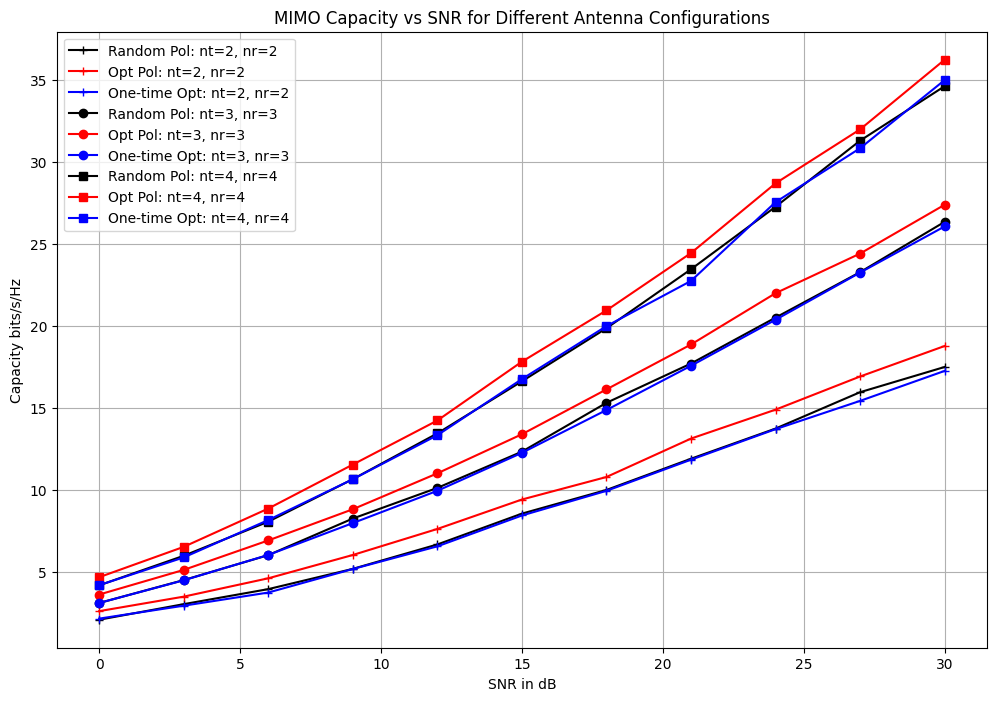

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig

# Clear all variables and set up parameters
np.random.seed(None)

# Configuration
nt_V = [1, 2, 3, 4]
nr_V = [1, 2, 3, 4]

N0 = 1e-4
B = 1
Iteration = 100  # Adjust as needed
N_Joint_PrePostCoding = 5

# SNR_V_db = np.arange(-10, 21, 3)  # original
SNR_V_db = np.arange(0, 31, 3)  # high SNR
SNR_V = 10**(SNR_V_db/10)

# Colors and notations for plotting
color = ['k', 'k', 'k', 'k', 'k']
notation = ['-x', '-+', '-o', '-s', '-^']
color_optPol = ['r', 'r', 'r', 'r', 'r']
color_OnetimeOptPol = ['b', 'b', 'b', 'b', 'b']

# Main simulation loop for different antenna configurations
plt.figure(figsize=(12, 8))

for k in range(1, 4):  # k = 2:4 in MATLAB (Python: 1, 2, 3)
    nt = nt_V[k]
    nr = nr_V[k]
    
    # Initialize capacity arrays
    Capacity = np.zeros((len(SNR_V), Iteration))
    Capacity_optPol = np.zeros((len(SNR_V), Iteration))
    Capacity_worstPol = np.zeros((len(SNR_V), Iteration))
    Capacity_OnetimeOptPol = np.zeros((len(SNR_V), Iteration))
    
    for i in range(len(SNR_V)):
        Pt = N0 * SNR_V[i]
        
        for n_iteration in range(Iteration):
            print(f"Antenna config: {nt}x{nr}, SNR: {SNR_V_db[i]} dB, Iteration: {n_iteration + 1}")
            
            # Initialize polarization vectors
            Pol_Tx = np.zeros((nt, 2))
            Pol_Rx = np.zeros((nr, 2))
            Pol_Tx_Opt = np.zeros((nt, 2))
            Pol_Rx_Opt = np.zeros((nr, 2))
            Pol_Tx_Worst = np.zeros((nt, 2))
            Pol_Rx_Worst = np.zeros((nr, 2))
            Pol_Tx_OnetimeOpt = np.zeros((nt, 2))
            H_PD_Tx = np.zeros((nt, 2, 2), dtype=complex)
            H_PD_Rx = np.zeros((nr, 2, 2), dtype=complex)
            theta_Tx = np.zeros(nt)
            theta_Rx = np.zeros(nr)
            theta_Tx_OnetimeOpt = np.zeros(nt)
            
            # Generate channel matrices
            H_re = np.random.normal(0, 1, (nr, nt))
            H_im = np.random.normal(0, 1, (nr, nt))
            H_randPol = (H_re + 1j*H_im) / np.sqrt(2)
            H_optPol = (H_re + 1j*H_im) / np.sqrt(2)
            H_worstPol = (H_re + 1j*H_im) / np.sqrt(2)
            H_OnetimeOptPol = (H_re + 1j*H_im) / np.sqrt(2)
            
            # Generate polarized channel matrices
            H_p_re = np.random.normal(0, 1, (nr, nt, 2, 2))
            H_p_im = np.random.normal(0, 1, (nr, nt, 2, 2))
            H_p = (H_p_re + 1j*H_p_im) / np.sqrt(2)
            
            # Random setting of Rx-Pol. vectors
            for n_Rx in range(nr):
                theta_rand_Rx = np.random.rand() * (2*np.pi)
                Pol_Rx[n_Rx, 0] = np.cos(theta_rand_Rx)
                Pol_Rx[n_Rx, 1] = np.sin(theta_rand_Rx)
            
            # Random setting of Tx-Pol. vectors
            for n_Tx in range(nt):
                theta_rand_Tx = np.random.rand() * (2*np.pi)
                Pol_Tx[n_Tx, 0] = np.cos(theta_rand_Tx)
                Pol_Tx[n_Tx, 1] = np.sin(theta_rand_Tx)
            
            # Channel Capacity with Random Pol. vectors
            for n_Tx in range(nt):
                for n_Rx in range(nr):
                    Pol_Rx_temp = Pol_Rx[n_Rx, :].reshape(-1, 1)
                    Pol_Tx_temp = Pol_Tx[n_Tx, :].reshape(-1, 1)
                    H_p_temp = H_p[n_Rx, n_Tx, :, :]
                    H_randPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
            
            U, Sigma, V = svd(H_randPol)
            lambdas = Sigma[:min(nt, nr)]
            Capacity[i, n_iteration], _ = WaterFilling_alg(Pt, lambdas, B, N0)
            
            # Channel Capacity with One-time Opt Tx-Pol. vectors
            for n_Tx in range(nt):
                H_PD_Tx_temp = np.zeros((2, 2), dtype=complex)
                for n_Rx in range(nr):
                    H_p_temp = H_p[n_Rx, n_Tx, :, :]
                    Pol_Rx_temp = Pol_Rx[n_Rx, :].reshape(-1, 1)
                    H_PD_Tx_temp = H_PD_Tx_temp + H_p_temp.T @ Pol_Rx_temp @ Pol_Rx_temp.T @ H_p_temp
                
                eigenvalues, eigenvectors = eig(H_PD_Tx_temp.real)
                I_lamda_PD_max = np.argmax(eigenvalues)
                theta_Tx_OnetimeOpt[n_Tx] = np.angle(eigenvectors[0, I_lamda_PD_max] + 
                                                     1j * eigenvectors[1, I_lamda_PD_max])
                Pol_Tx_OnetimeOpt[n_Tx, 0] = np.cos(theta_Tx_OnetimeOpt[n_Tx])
                Pol_Tx_OnetimeOpt[n_Tx, 1] = np.sin(theta_Tx_OnetimeOpt[n_Tx])
            
            # H_OnetimeOptPol: H matrix with one-time optimized polarization
            for n_Tx in range(nt):
                for n_Rx in range(nr):
                    Pol_Rx_temp = Pol_Rx[n_Rx, :].reshape(-1, 1)
                    Pol_Tx_temp = Pol_Tx_OnetimeOpt[n_Tx, :].reshape(-1, 1)
                    H_p_temp = H_p[n_Rx, n_Tx, :, :]
                    H_OnetimeOptPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
            
            U, Sigma, V = svd(H_OnetimeOptPol)
            lambdas_OnetimeOptPol = Sigma[:min(nt, nr)]
            Capacity_OnetimeOptPol[i, n_iteration], _ = WaterFilling_alg(Pt, lambdas_OnetimeOptPol, B, N0)
            
            # Channel Capacity with Opt and Worst Pol. vectors (Joint optimization)
            for n_PrePostCoding in range(N_Joint_PrePostCoding):
                # Tx-Pol precoding
                for n_Tx in range(nt):
                    H_PD_Tx_temp = np.zeros((2, 2), dtype=complex)
                    for n_Rx in range(nr):
                        H_p_temp = H_p[n_Rx, n_Tx, :, :]
                        Pol_Rx_Opt_temp = Pol_Rx_Opt[n_Rx, :].reshape(-1, 1)
                        H_PD_Tx_temp = H_PD_Tx_temp + H_p_temp.T @ Pol_Rx_Opt_temp @ Pol_Rx_Opt_temp.T @ H_p_temp
                    
                    eigenvalues, eigenvectors = eig(H_PD_Tx_temp.real)
                    I_lamda_PD_max = np.argmax(eigenvalues)
                    theta_Tx[n_Tx] = np.angle(eigenvectors[0, I_lamda_PD_max] + 
                                             1j * eigenvectors[1, I_lamda_PD_max])
                    Pol_Tx_Opt[n_Tx, 0] = np.cos(theta_Tx[n_Tx])
                    Pol_Tx_Opt[n_Tx, 1] = np.sin(theta_Tx[n_Tx])
                    Pol_Tx_Worst[n_Tx, 0] = np.cos(theta_Tx[n_Tx] + np.pi/2)
                    Pol_Tx_Worst[n_Tx, 1] = np.sin(theta_Tx[n_Tx] + np.pi/2)
                
                # Rx-Pol postcoding
                for n_Rx in range(nr):
                    H_PD_Rx_temp = np.zeros((2, 2), dtype=complex)
                    for n_Tx in range(nt):
                        H_p_temp = H_p[n_Rx, n_Tx, :, :]
                        Pol_Tx_Opt_temp = Pol_Tx_Opt[n_Tx, :].reshape(-1, 1)
                        H_PD_Rx_temp = H_PD_Rx_temp + H_p_temp @ Pol_Tx_Opt_temp @ Pol_Tx_Opt_temp.T @ H_p_temp.T
                    
                    eigenvalues, eigenvectors = eig(H_PD_Rx_temp.real)
                    I_lamda_PD_max = np.argmax(eigenvalues)
                    theta_Rx[n_Rx] = np.angle(eigenvectors[0, I_lamda_PD_max] + 
                                             1j * eigenvectors[1, I_lamda_PD_max])
                    Pol_Rx_Opt[n_Rx, 0] = np.cos(theta_Rx[n_Rx])
                    Pol_Rx_Opt[n_Rx, 1] = np.sin(theta_Rx[n_Rx])
                    Pol_Rx_Worst[n_Rx, 0] = np.cos(theta_Rx[n_Rx] + np.pi/2)
                    Pol_Rx_Worst[n_Rx, 1] = np.sin(theta_Rx[n_Rx] + np.pi/2)
            
            # H_optPol: H matrix with optimized polarization vectors
            for n_Rx in range(nr):
                for n_Tx in range(nt):
                    Pol_Rx_Opt_temp = Pol_Rx_Opt[n_Rx, :].reshape(-1, 1)
                    Pol_Tx_Opt_temp = Pol_Tx_Opt[n_Tx, :].reshape(-1, 1)
                    H_p_temp = H_p[n_Rx, n_Tx, :, :]
                    H_optPol[n_Rx, n_Tx] = (Pol_Rx_Opt_temp.T @ H_p_temp @ Pol_Tx_Opt_temp).item()
                    
                    # The worst Pol case
                    Pol_Rx_temp = Pol_Rx_Worst[n_Rx, :].reshape(-1, 1)
                    Pol_Tx_temp = Pol_Tx_Worst[n_Tx, :].reshape(-1, 1)
                    H_worstPol[n_Rx, n_Tx] = (Pol_Rx_temp.T @ H_p_temp @ Pol_Tx_temp).item()
            
            # Capacity for Opt. Pol scenario
            U_optPol, Sigma_optPol, V_optPol = svd(H_optPol)
            lambdas_optPol = Sigma_optPol[:min(nt, nr)]
            Capacity_optPol[i, n_iteration], _ = WaterFilling_alg(Pt, lambdas_optPol, B, N0)
            
            # Capacity for Worst Pol scenario
            U_worstPol, Sigma_worstPol, V_worstPol = svd(H_worstPol)
            lambdas_worstPol = Sigma_worstPol[:min(nt, nr)]
            Capacity_worstPol[i, n_iteration], _ = WaterFilling_alg(Pt, lambdas_worstPol, B, N0)
    
    # Plot results
    plt.plot(SNR_V_db, np.mean(Capacity, axis=1), notation[k], color=color[k], 
             label=f'Random Pol: nt={nt}, nr={nr}')
    plt.plot(SNR_V_db, np.mean(Capacity_optPol, axis=1), notation[k], 
             color=color_optPol[k], label=f'Opt Pol: nt={nt}, nr={nr}')
    plt.plot(SNR_V_db, np.mean(Capacity_OnetimeOptPol, axis=1), notation[k], 
             color=color_OnetimeOptPol[k], label=f'One-time Opt: nt={nt}, nr={nr}')

plt.grid(True)
plt.xlabel('SNR in dB')
plt.ylabel('Capacity bits/s/Hz')
plt.legend()
plt.title('MIMO Capacity vs SNR for Different Antenna Configurations')
plt.show()